# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset

EPS = 1.0e-7

In [2]:
# # IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# # mount drive: WE NEED IT FOR SAVING IMAGES!
# from google.colab import drive

# drive.mount("/content/gdrive")

In [3]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
results_dir = "/content/gdrive/My_Drive/Colab Notebooks/TEACHING/"

In [4]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

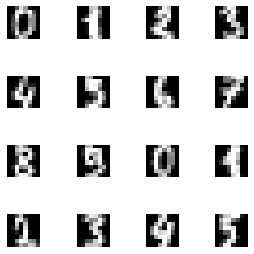

In [5]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [6]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [7]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
# =========
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        
        # We provide a sequential module with layers and activations
        self.classnet = classnet # classifier network - our actual classif function
        
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!! # our loss function
        
        # we have 8x8 pixels, each pixel is an input param, so it would be 64 dim problem. 

    # This function classifies an image x to a class.
    # The output must be a class label (long). # return log vals not actual label as such
    def classify(self, x):
        
        # passing the input through the classnet first
        y_pred = self.classnet(x)
        # applying argmax to get the highest log likelihood prob aka most likely label
        y_pred =  y_pred.argmax(dim=1)

        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        
        # run thru classnet to get longs
        y_pred = self.classnet(x)
        # as defined below, the cdde tranlation of the mathematical nll formula requires the actual label and the probability (long is for correct formatting)
        loss = self.nll(y_pred, y.long())
        
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:**
The objective function for a classification task qith multiple classes is in our case the Negative log likelihood loss, which we use by nn.NLLLoss. In general, it gives how likely our model is to correctly predicts the class label for our data. It is something we try to minimize which is essetnially the same as improving the quality of our algortihm (accuracy of label prediction) in layman's terms. NLLLoss is calculated by taking the negative sum of y times log of p, -sum(y*log(p)) where y is the correct/actual label is p is the probability of that label. More deeply Negative log likelihood loss can be defined as  -\sum_{i=1}^n y_i \log p_i which is the same but more formally correct, where n is the number of instances we look at and then iterate over each y and its log(p).

**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** It is correct to use the log version for making predictions, and we need to use it as our forward function calls for it (when calculating loss). Logs are inherintly better when dealing with small numbers, as it is a less unstable. So, in our case, the log probabilities are more stable thanjust softmax probabilities would be. Other than the forward method, we also use the log softmax in 'classify' which is where the actual prediciton are being output. Here, it takes the highest log probability and using argmax chooses it, resulting in returning the most likely label. sing the log version gives more mathematically stable results less prone to small errors.

### 2.2 Evaluation

In [8]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

### 2.3 Training procedure

In [9]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [10]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [11]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
print(f"Feature example shape: {train_data[1][0].shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [12]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1, 8, 8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [13]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=1.8367610931396485, val ce=0.6657142857142857
Epoch: 10, val nll=0.26246967588152204, val ce=0.05714285714285714
Epoch: 20, val nll=0.1653176416669573, val ce=0.03142857142857143
Epoch: 30, val nll=0.12882167475564138, val ce=0.02857142857142857
Epoch: 40, val nll=0.11007740838187081, val ce=0.025714285714285714
Epoch: 50, val nll=0.10178965296064105, val ce=0.025714285714285714
Epoch: 60, val nll=0.09623388051986695, val ce=0.025714285714285714
Epoch: 70, val nll=0.09078118290219989, val ce=0.025714285714285714
Epoch: 80, val nll=0.08876285757337297, val ce=0.02857142857142857
Epoch: 90, val nll=0.08389317308153425, val ce=0.025714285714285714
Epoch: 100, val nll=0.08459180099623544, val ce=0.025714285714285714
Epoch: 110, val nll=0.0841798986707415, val ce=0.025714285714285714
Epoch: 120, val nll=0.08376552036830358, val ce=0.025714285714285714
-> FINAL PERFORMANCE: nll=0.28714609199455654, ce=0.08053691275167785


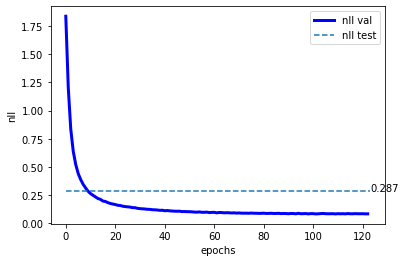

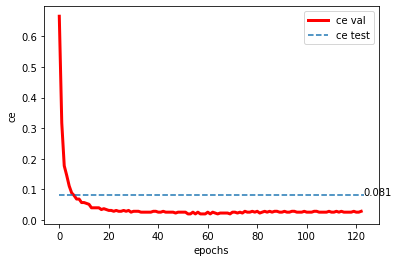


-> START classifier_cnn
Epoch: 0, val nll=1.3082183401925223, val ce=0.20285714285714285
Epoch: 10, val nll=0.10551141193934849, val ce=0.02857142857142857
Epoch: 20, val nll=0.0825446925844465, val ce=0.022857142857142857
Epoch: 30, val nll=0.07203603991440365, val ce=0.017142857142857144
Epoch: 40, val nll=0.06795065509421484, val ce=0.02
Epoch: 50, val nll=0.06483305960893632, val ce=0.017142857142857144
Epoch: 60, val nll=0.06703079330069678, val ce=0.02
Epoch: 70, val nll=0.062472144940069745, val ce=0.017142857142857144
Epoch: 80, val nll=0.06394098092402731, val ce=0.017142857142857144
Epoch: 90, val nll=0.06367448012743677, val ce=0.017142857142857144
Epoch: 100, val nll=0.06424366402838912, val ce=0.017142857142857144
-> FINAL PERFORMANCE: nll=0.2567198340524763, ce=0.06711409395973154


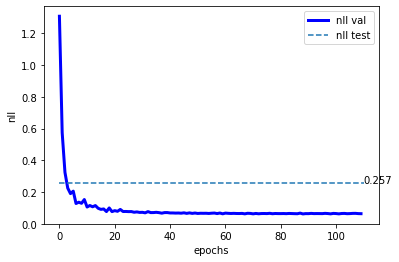

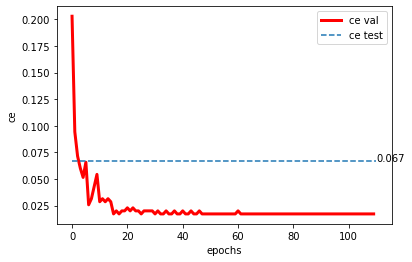

In [14]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential( 

            # local function that reshapes a matrix to a vector (grid to line)
            Flatten(),
            # lin layer w/ 64 input features and 100 output
            nn.Linear(64, 100), 
            # ReLU activation function _/
            nn.ReLU(),  
            # size and amount of layers are up to me, but final lin layer must be 10 (10 nodes at end)
            nn.Linear(100, 10),
            # lsm activation at end as explained before
            nn.LogSoftmax(dim=1),  
            
            )
        
        # You are asked here to propose your own architecture
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        pass

    # CNN 
    # keeps the order of the pixels, the convolutional layer has a filter/kernel which moves over the image that create the next layer
    # in CNNs we are changing th kernel layer by layer, not the image (the kernel gets better)
    # add padding of the same type as background so your image does not get smaller
    elif name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            
            # another local function that reshpaes the input into a 4D tensor with specified dims
            Reshape([1, 8, 8]),
            # first convolution layer with chosen kernel sie n padding
            nn.Conv2d(1, num_kernels, kernel_size=3, padding=1),
            # activation _/
            nn.ReLU(),
            # decided to add second conv layer for complexity~
            nn.Conv2d(num_kernels, num_kernels, kernel_size=3, padding=1),
            # activation _/
            nn.ReLU(), 
            # found a powerful pooling method - 2D
            nn.MaxPool2d(2, 2), 
            # back to 1D
            Flatten(),
            # linear again with more input features
            nn.Linear(num_kernels * 4 * 4, 100), 
            # activation _/
            nn.ReLU(),
            # final layer to ensire resulting size 10
            nn.Linear(100, 10),  
            # LogSoftMax as required to run properly
            nn.LogSoftmax(dim=1),
        )
        #
        # You are asked here to propose your own architecture
        # NOTE: Plese note that the images are represented as vectors, thus, you must
        # use Reshape(size) as the first layer, and Flatten() after all convolutional
        # layers and before linear layers.
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        pass

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: Both our algorithms converge to a quite low loss/error which is good, but is in interesing to see the CNN converge faster. It makes sense tho, considering that CNN is more complex overall and can extract more and better features from the given data. CNNs use convolutional layers as oppoosed to a fully connected layers in MLP, which allow CNNs to focus more locally inside each data while MLPs remain more general/overall in their approach to learning features. Thus, we can conclude that CNNs use their ability to learn more complex features from the data to converge faster. Our CNN is lower, though not by much in both loss (0.2567198340524763 vs  0.28714609199455654) as well as class. error (0.06711409395973154 vs 0.08053691275167785) in its final performance and during the training it had a sharper decline though also wasn't as smooth sialing as MLP was. (images in pdf version)

**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: It seems to be that way thought this may be a case of dataset so simple a more powerful architecture is wasted. But, CNN was better overall and form past experience I know it is better for image processing than MLP. It has a few advantages, one which was mentioned above and that is the ability to learn local features fue to the use of conv layers, rhather than petterns in the image overall, which results in more precise and sensitive image recognition. 

## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

In [15]:
# Load in the data yourself
# But otherwise its mostly copy paste
# the output should be digit in the center of the image so 0-9 again

In [16]:
import numpy as np
from scipy.io import loadmat
from sklearn.utils import shuffle

# found method to downlaod it from within the code using torchvision but also sklearn
class SVHNDataset:
    def __init__(self, mode="train", transforms=None):
        svhn = loadmat('/dataset/train_32x32.mat')
        # format coppied from previous part
        if mode == "train":
            # .astype is probably wrong, but i end up tranforming toTensor as was mentione anyway and this version runs without errors
            self.data = svhn['X'][:1000].transpose(3, 0, 1, 2).astype(np.float32)
            self.targets = svhn['y'][:1000].reshape(-1)
        elif mode == "val":
            self.data = svhn['X'][1000:1350].transpose(3, 0, 1, 2).astype(np.float32)
            self.targets = svhn['y'][1000:1350].reshape(-1)
        else:
            self.data = svhn['X'][1350:].transpose(3, 0, 1, 2).astype(np.float32)
            self.targets = svhn['y'][1350:].reshape(-1)
            
        # add shuffle bcs we are not using all data and we dont want to overfit our model
        self.data, self.targets = shuffle(self.data, self.targets)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return sample_x, sample_y


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat
Epoch: 0, val nll=0.36420340118643574, val ce=0.10504115647651419
Epoch: 10, val nll=0.11532345648285883, val ce=0.03139631707550132
Epoch: 20, val nll=0.05574742349548308, val ce=0.014988328760391498
Epoch: 30, val nll=0.025627446491487633, val ce=0.0067160817396289775
Epoch: 40, val nll=0.017674987877416393, val ce=0.0049415072962310765
-> FINAL PERFORMANCE: nll=0.31603535226550233, ce=0.06580362630608481


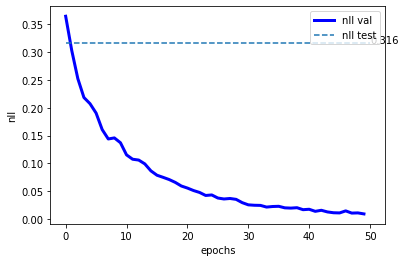

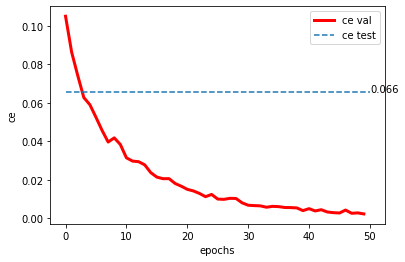

In [33]:
# defined hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 50

# transform (tho i think the import is already doing this)
transforms = ToTensor()

# created train, validation, and test datasets as per previous code, check for download so it doesnt do it every run
train_dataset = SVHN(root='./data', split='train', download=True, transform=transforms)
val_dataset = SVHN(root='./data', split='train', download=True, transform=transforms)
test_dataset = SVHN(root='./data', split='test', download=True, transform=transforms)

# rewrite loaders, included shuffle bcs its a good idea
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# removed loop bcs we are only running CNN
classnet = nn.Sequential(
    # used the same pooling and activation as before, but addedd normalization by batch as well as dropout to increase performace
    # so I would get the best in the least epochs
    # the numbers were mostly brute-forced until I stopped getting the math errors ;_;
    nn.Conv2d(in_channels=3, out_channels=40, kernel_size=(5,5), padding=1, stride=1),
    # first 2d batchnorm, the feature size is unnecessarily large
    nn.BatchNorm2d(num_features=40),
    nn.ReLU(),
    # i could only get 3,3 and stride 2 to work for both datasets for some reason
    nn.MaxPool2d(kernel_size=(3,3), stride=2),
    # i started with lower droput and steadily increased, tho I am not sure if it changes much as it is too long to run ore times
    nn.Dropout2d(p=0.1),
    # and then I repeat with different, usually rising numbers
    nn.Conv2d(in_channels=40, out_channels=80, kernel_size=(5,5), padding=1, stride=1),
    nn.BatchNorm2d(num_features=80),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(3,3), stride=2),
    nn.Dropout2d(p=0.2),
    # another round
    nn.Conv2d(in_channels=80, out_channels=160, kernel_size=(5,5), padding=1, stride=1),
    nn.BatchNorm2d(num_features=160),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(3,3), stride=2),
    # the flatten here is a bit early, I wanted to try less dims
    Flatten(),
    nn.Linear(in_features=160, out_features=128),
    nn.BatchNorm1d(num_features=128),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    # finally done
    nn.Linear(in_features=128, out_features=10),
    nn.LogSoftmax(dim=1)
)



#all this code is coppied from the previous part

    # Init ClassifierNN
model = ClassifierNeuralNet(classnet)
   # Init OPTIMIZER (here we use ADAMAX)
optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
)
    # Training procedure
nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=train_loader,
        val_loader=val_loader,
    )
    # The final evaluation (on the test set)
test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
# write the results to a file
f = open(result_dir + name + "_test_loss.txt", "w")
f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
f.close()
# create curves
plot_curve(
    result_dir + name,
    nll_val,
    file_name="_nll_val_curve.pdf",
    ylabel="nll",
    test_eval=test_loss,
)
plot_curve(
    result_dir + name,
    error_val,
    file_name="_ca_val_curve.pdf",
    ylabel="ce",
    color="r-",
    test_eval=test_error,
)

**Extra features:** I added Batch Normalization and Droput which we talked about in ML everywhere to improve the performance, but also these were mothids suggesteed for better perfomance on the internet. My idea was to see if I could get a one time home-run, and then if I run it long enough potentially even to get it to overfit just to get a better understanding of the inner working of the code. It was extremely hard to get it to match mathematically, I kept getting math errors but eventually I got a beefy CNN to run. Eseentially it is the same as the original CNN, with extra steps. I tried to keep it 2D most of the time as that is the pooling I used succesfully before, but also tried the 1D after flatten just to prove that it is still possible without breaking it. 

**Architecture:** The achitecture is almost the exact same as with the first CNN, though we have a new Dataset and we added both batch normalization and dropout to each layer. We also increased the number of in-between layers to 4 to create a more powerful cnn. The testing and validation code is all otherwise the same. I have also removed the loop inside which the CNN class was as we are no longer running both MLP and CNN. I am reusing the whole classification code as I have alrady spent time implementing it and it seems to work great. Thus, we are using Negaive Log Likelihood Loss here as well, and thus I kep Log SoftMax as final function inside the CNN. Originally I ran it just 10 epoch which got me around 0.8 CE which is more than good enough but I also ran for longer to get a nicer graph (the first one looked like a crooked diagonal line) and as previously mentioned to see if I can get it to overfit. (Unlikely given my limited computational power) Many of the componenets are explained in the comments if they are new, but otherwise the code is mostly reused :)

**Analysis:** In the original 10 epoch run, it was already clear that the CNN was increadibly powerful. Not only did it take forever to run, it also was able to get the asked for result of CE >0.1 within the 10 epochs. The graph looked like a crooked diagonal line, showing a steady progress towards the final model's accuracy. There was a plateu between 5 and 6th epoch, which I assume could have been through either sheer statistical probability or potentially the result of using logs. Logs are less prone to small changes, so it is possible the learing between these two epochs wasn't significant enough to affect the loss when using logs. The final run, which took about 3 hours, of 50 epochs was done to see if something weird would happen, such as overfitting. We have seen such a graph, that goes back up in class but I realized I am probabbly overestimating the quality of the CNN. I am using very large feature sizes which I suspect to be the biggest contributor to the quick convergence, as that is what is the backbone of CNNs in my understanding. I also suspect the CNN is unnecessarily complicated and I could ahve achived the same or better result using less layers and different methods. The final accuracy of the 50 epoch run was: -> FINAL PERFORMANCE: nll=0.31603535226550233, ce=0.06580362630608481, which is much less than we got during trainng on the validation set (Epoch: 40, val nll=0.017674987877416393, val ce=0.0049415072962310765). I suspect this is tangentially related to the overfitting I was expecting. Not exactly, but it got much better on the data it knew but nowehere near the same onyet unknown images. The difference is much larger than in the previous runs, and I am happy to see it for learning purposes. The graphs look very nive however, a smooth line much nicer than the first cnn. I suspect this is teh result of each run's complexity which allows for less variability between adjacent runs.